# Phase 2: Centroid Visualization

This notebook visualizes the centroids computed from LLM embeddings for each key-value pair.

**Input Data:**
- `centroids.json`: Centroid vectors for each unique value of each key
- `embeddings.npz`: Original embeddings for reference

**Visualizations:**
1. Centroid counts per key (bar chart)
2. PCA of centroids for "road_type" (6 values)
3. PCA of centroids for "weather" (4 values)
4. Centroid distance matrix for "safety_criticality" (heatmap)
5. Angular separation between centroids for selected keys

In [1]:
import json
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.metrics.pairwise import cosine_distances, euclidean_distances
from pathlib import Path

# Configuration
plt.rcParams['figure.dpi'] = 150
plt.rcParams['savefig.dpi'] = 150
plt.rcParams['font.size'] = 10

# Paths
DATA_DIR = Path('/Users/kaiser/Projects/Masterarbeit/data/runs/classification_20260120')
FIGURE_DIR = DATA_DIR / 'figures'
FIGURE_DIR.mkdir(exist_ok=True)

## Load Data

In [2]:
# Load centroids
with open(DATA_DIR / 'centroids.json', 'r') as f:
    centroids_data = json.load(f)

print(f'Number of keys: {len(centroids_data)}')
print(f'Keys: {list(centroids_data.keys())}')

Number of keys: 19
Keys: ['weather', 'time_of_day', 'road_type', 'traffic_situation', 'pedestrians_present', 'cyclists_present', 'construction_activity', 'traffic_signals_visible', 'vehicle_count', 'occlusion_level', 'depth_complexity', 'nearest_vehicle_distance', 'visual_degradation', 'similar_object_confusion', 'safety_criticality', 'vulnerable_road_users', 'required_action', 'pedestrian_count', 'vehicle_count_by_type']


In [3]:
# Helper function to extract centroids for a key
def get_centroids_for_key(key_name):
    """Extract centroid vectors and their labels for a specific key."""
    key_data = centroids_data[key_name]
    values = list(key_data.keys())
    centroids = np.array([key_data[v]['centroid'] for v in values])
    return values, centroids

# Test with weather
values, centroids = get_centroids_for_key('weather')
print(f'Weather values: {values}')
print(f'Centroid shape: {centroids.shape}')

Weather values: ['foggy', 'clear', 'cloudy', 'rainy']
Centroid shape: (4, 4096)


## 1. Centroid Counts per Key

Bar chart showing the number of unique values (centroids) for each key.

In [4]:
# Count unique values per key
key_counts = {key: len(centroids_data[key]) for key in centroids_data}
keys_sorted = sorted(key_counts.keys(), key=lambda x: key_counts[x], reverse=True)
counts_sorted = [key_counts[k] for k in keys_sorted]

print('Centroid counts per key:')
for k in keys_sorted:
    print(f'  {k}: {key_counts[k]}')

Centroid counts per key:
  vehicle_count_by_type: 20
  vehicle_count: 15
  nearest_vehicle_distance: 12
  road_type: 6
  visual_degradation: 6
  vulnerable_road_users: 5
  weather: 4
  traffic_situation: 4
  occlusion_level: 4
  safety_criticality: 4
  required_action: 4
  pedestrian_count: 4
  time_of_day: 3
  pedestrians_present: 2
  construction_activity: 2
  traffic_signals_visible: 2
  depth_complexity: 2
  similar_object_confusion: 2
  cyclists_present: 1


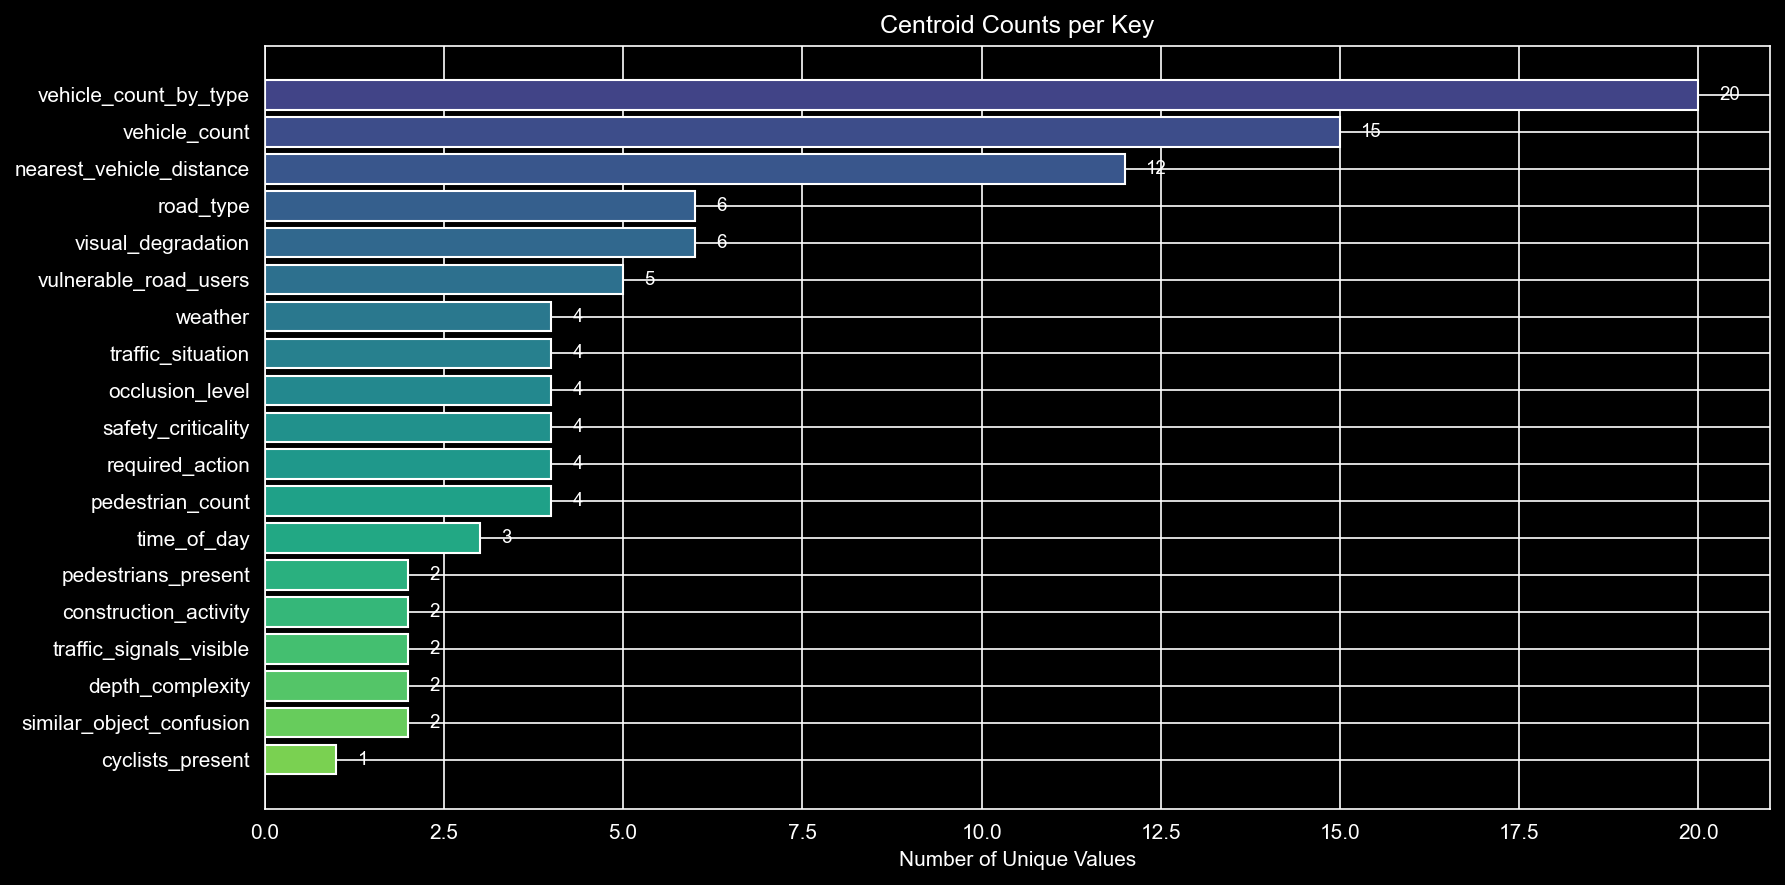

In [5]:
# Plot bar chart
fig, ax = plt.subplots(figsize=(12, 6))

colors = plt.cm.viridis(np.linspace(0.2, 0.8, len(keys_sorted)))
bars = ax.barh(range(len(keys_sorted)), counts_sorted, color=colors)

ax.set_yticks(range(len(keys_sorted)))
ax.set_yticklabels(keys_sorted)
ax.set_xlabel('Number of Unique Values')
ax.set_title('Centroid Counts per Key')
ax.invert_yaxis()

# Add count labels
for i, (bar, count) in enumerate(zip(bars, counts_sorted)):
    ax.text(bar.get_width() + 0.3, bar.get_y() + bar.get_height()/2,
            str(count), va='center', fontsize=9)

plt.tight_layout()
fig.savefig(FIGURE_DIR / '02_centroid_counts.png', bbox_inches='tight')
plt.show()

## 2. PCA of Centroids for "road_type"

Visualize the 6 road type centroids in 2D space using PCA.

In [6]:
# Get road_type centroids
road_values, road_centroids = get_centroids_for_key('road_type')
print(f'Road type values: {road_values}')
print(f'Centroids shape: {road_centroids.shape}')

Road type values: ['highway', 'rural', 'urban_street', 'intersection', 'residential', 'parking_lot']
Centroids shape: (6, 4096)


In [7]:
# PCA
pca_road = PCA(n_components=2, random_state=42)
road_coords = pca_road.fit_transform(road_centroids)

print(f'Explained variance: {pca_road.explained_variance_ratio_}')
print(f'Total explained: {sum(pca_road.explained_variance_ratio_):.2%}')

Explained variance: [0.3030776  0.21871539]
Total explained: 52.18%


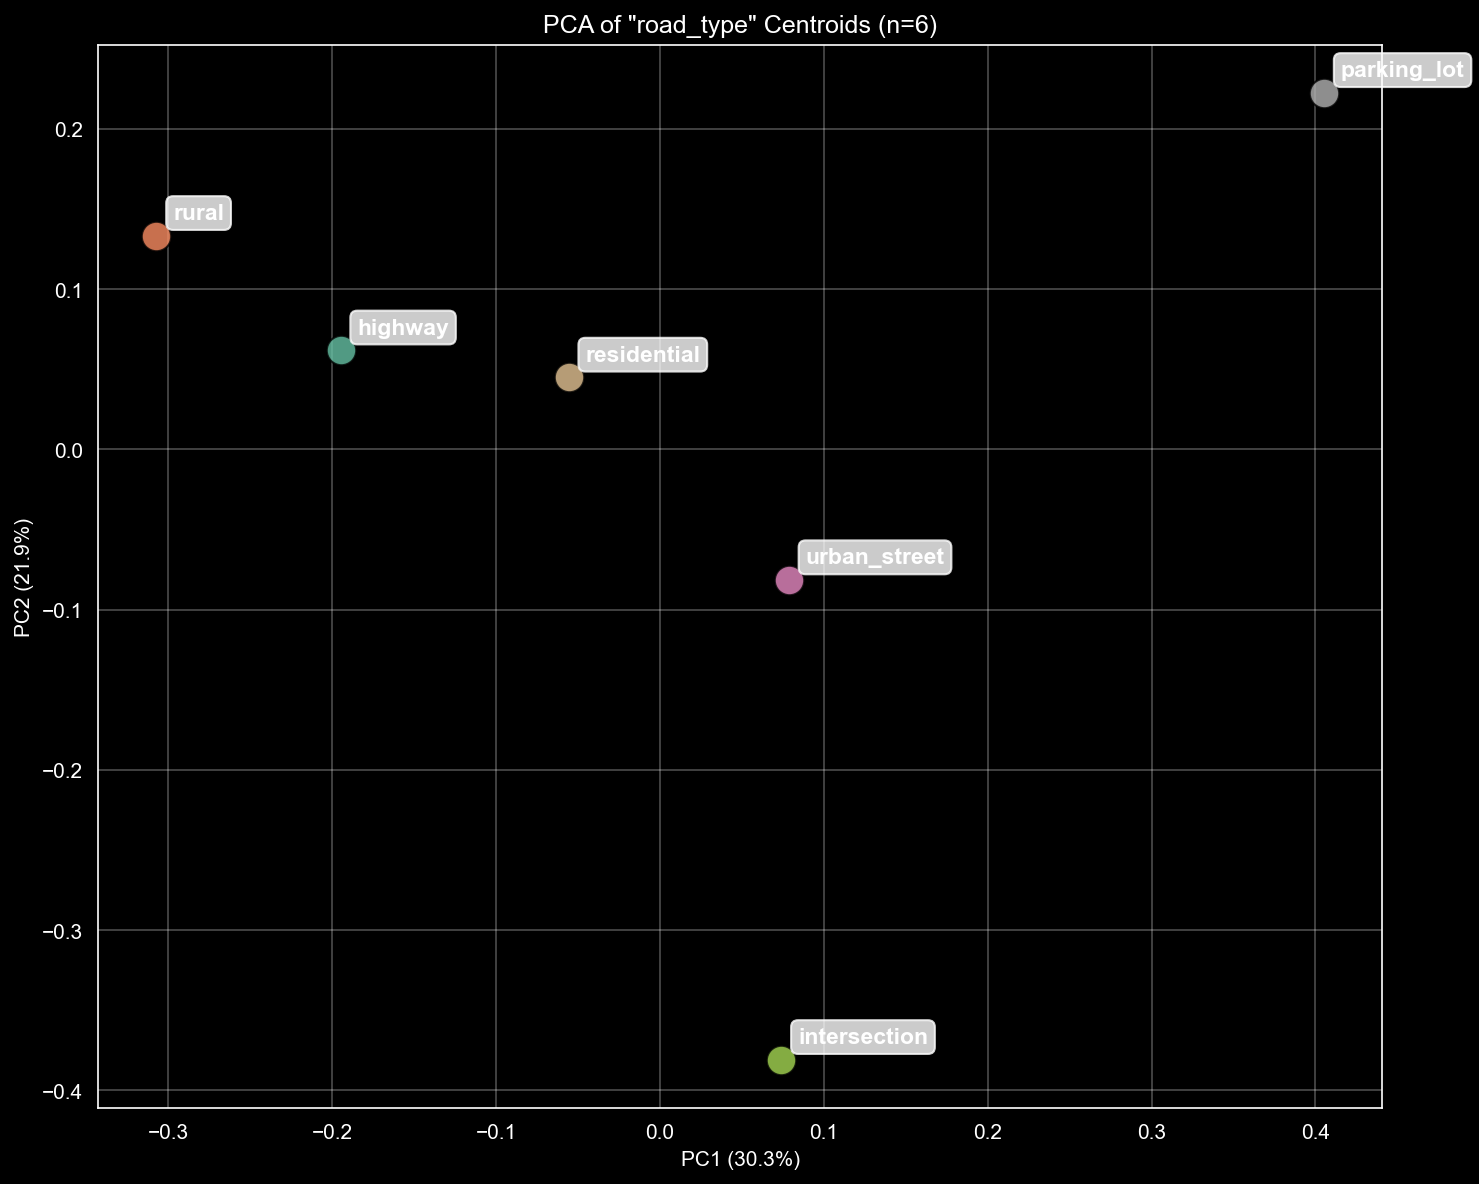

In [8]:
# Plot
fig, ax = plt.subplots(figsize=(10, 8))

colors = plt.cm.Set2(np.linspace(0, 1, len(road_values)))

for i, (val, coord) in enumerate(zip(road_values, road_coords)):
    ax.scatter(coord[0], coord[1], c=[colors[i]], s=200, alpha=0.8, edgecolors='black', linewidth=1)
    ax.annotate(val, (coord[0], coord[1]), 
                xytext=(8, 8), textcoords='offset points',
                fontsize=11, fontweight='bold',
                bbox=dict(boxstyle='round,pad=0.3', facecolor='white', alpha=0.8))

ax.set_xlabel(f'PC1 ({pca_road.explained_variance_ratio_[0]:.1%})')
ax.set_ylabel(f'PC2 ({pca_road.explained_variance_ratio_[1]:.1%})')
ax.set_title('PCA of "road_type" Centroids (n=6)')
ax.grid(True, alpha=0.3)
plt.tight_layout()

fig.savefig(FIGURE_DIR / '02_centroids_road_type.png', bbox_inches='tight')
plt.show()

## 3. PCA of Centroids for "weather"

Visualize the 4 weather centroids in 2D space.

In [9]:
# Get weather centroids
weather_values, weather_centroids = get_centroids_for_key('weather')
print(f'Weather values: {weather_values}')
print(f'Centroids shape: {weather_centroids.shape}')

Weather values: ['foggy', 'clear', 'cloudy', 'rainy']
Centroids shape: (4, 4096)


In [10]:
# PCA
pca_weather = PCA(n_components=2, random_state=42)
weather_coords = pca_weather.fit_transform(weather_centroids)

print(f'Explained variance: {pca_weather.explained_variance_ratio_}')
print(f'Total explained: {sum(pca_weather.explained_variance_ratio_):.2%}')

Explained variance: [0.46228712 0.33688942]
Total explained: 79.92%


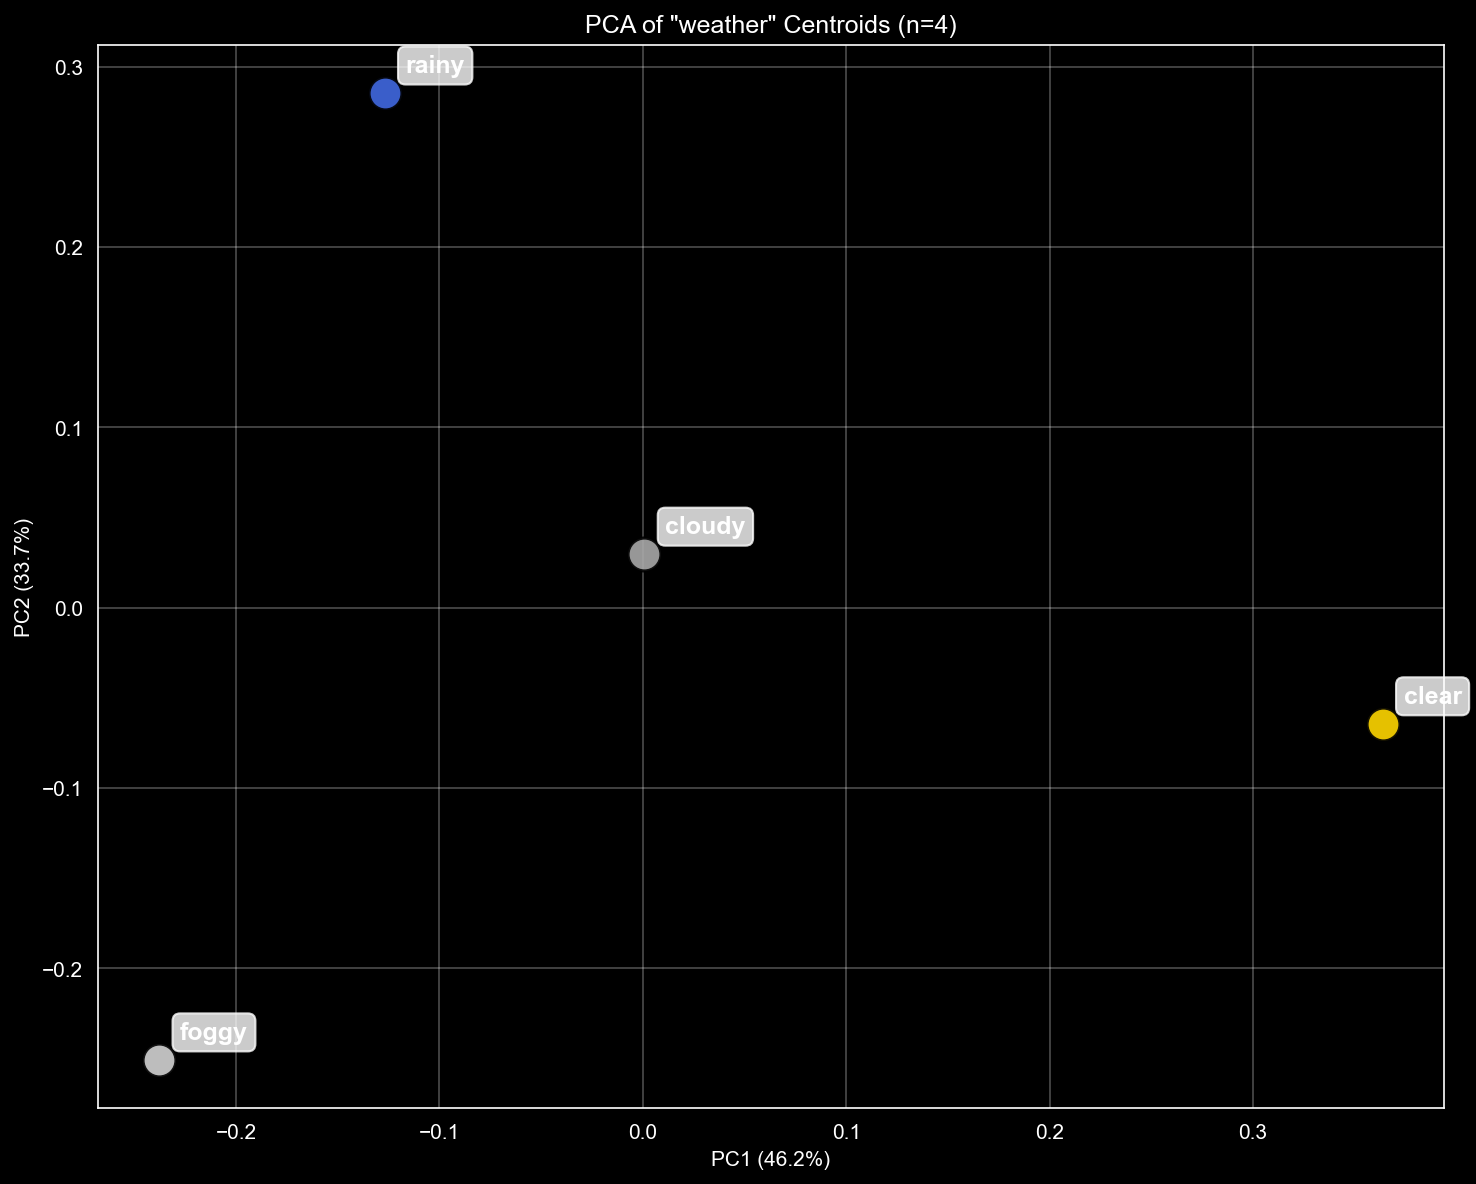

In [11]:
# Plot
fig, ax = plt.subplots(figsize=(10, 8))

# Use weather-appropriate colors
weather_colors = {
    'clear': '#FFD700',    # Gold/sunny
    'cloudy': '#A9A9A9',   # Gray
    'rainy': '#4169E1',    # Royal blue
    'foggy': '#D3D3D3'     # Light gray
}

for val, coord in zip(weather_values, weather_coords):
    color = weather_colors.get(val, '#888888')
    ax.scatter(coord[0], coord[1], c=color, s=250, alpha=0.9, edgecolors='black', linewidth=1.5)
    ax.annotate(val, (coord[0], coord[1]), 
                xytext=(10, 10), textcoords='offset points',
                fontsize=12, fontweight='bold',
                bbox=dict(boxstyle='round,pad=0.3', facecolor='white', alpha=0.8))

ax.set_xlabel(f'PC1 ({pca_weather.explained_variance_ratio_[0]:.1%})')
ax.set_ylabel(f'PC2 ({pca_weather.explained_variance_ratio_[1]:.1%})')
ax.set_title('PCA of "weather" Centroids (n=4)')
ax.grid(True, alpha=0.3)
plt.tight_layout()

fig.savefig(FIGURE_DIR / '02_centroids_weather.png', bbox_inches='tight')
plt.show()

## 4. Centroid Distance Matrix for "safety_criticality"

Heatmap showing pairwise Euclidean distances between safety criticality centroids.

In [12]:
# Get safety_criticality centroids
safety_values, safety_centroids = get_centroids_for_key('safety_criticality')
print(f'Safety criticality values: {safety_values}')
print(f'Centroids shape: {safety_centroids.shape}')

Safety criticality values: ['tier2_severe', 'tier1_catastrophic', 'tier3_moderate', 'tier4_minor']
Centroids shape: (4, 4096)


In [13]:
# Compute pairwise Euclidean distances
dist_matrix = euclidean_distances(safety_centroids)
print(f'Distance matrix shape: {dist_matrix.shape}')
print(f'Distance range: [{dist_matrix.min():.4f}, {dist_matrix.max():.4f}]')

Distance matrix shape: (4, 4)
Distance range: [0.0000, 0.5458]


In [14]:
# Sort values by severity for better visualization
severity_order = ['tier1_catastrophic', 'tier2_severe', 'tier3_moderate', 'tier4_minor']
sorted_indices = [safety_values.index(v) for v in severity_order if v in safety_values]
sorted_values = [safety_values[i] for i in sorted_indices]
sorted_dist_matrix = dist_matrix[np.ix_(sorted_indices, sorted_indices)]

# Clean up labels for display
display_labels = [v.replace('tier', 'Tier ').replace('_', ' ').title() for v in sorted_values]

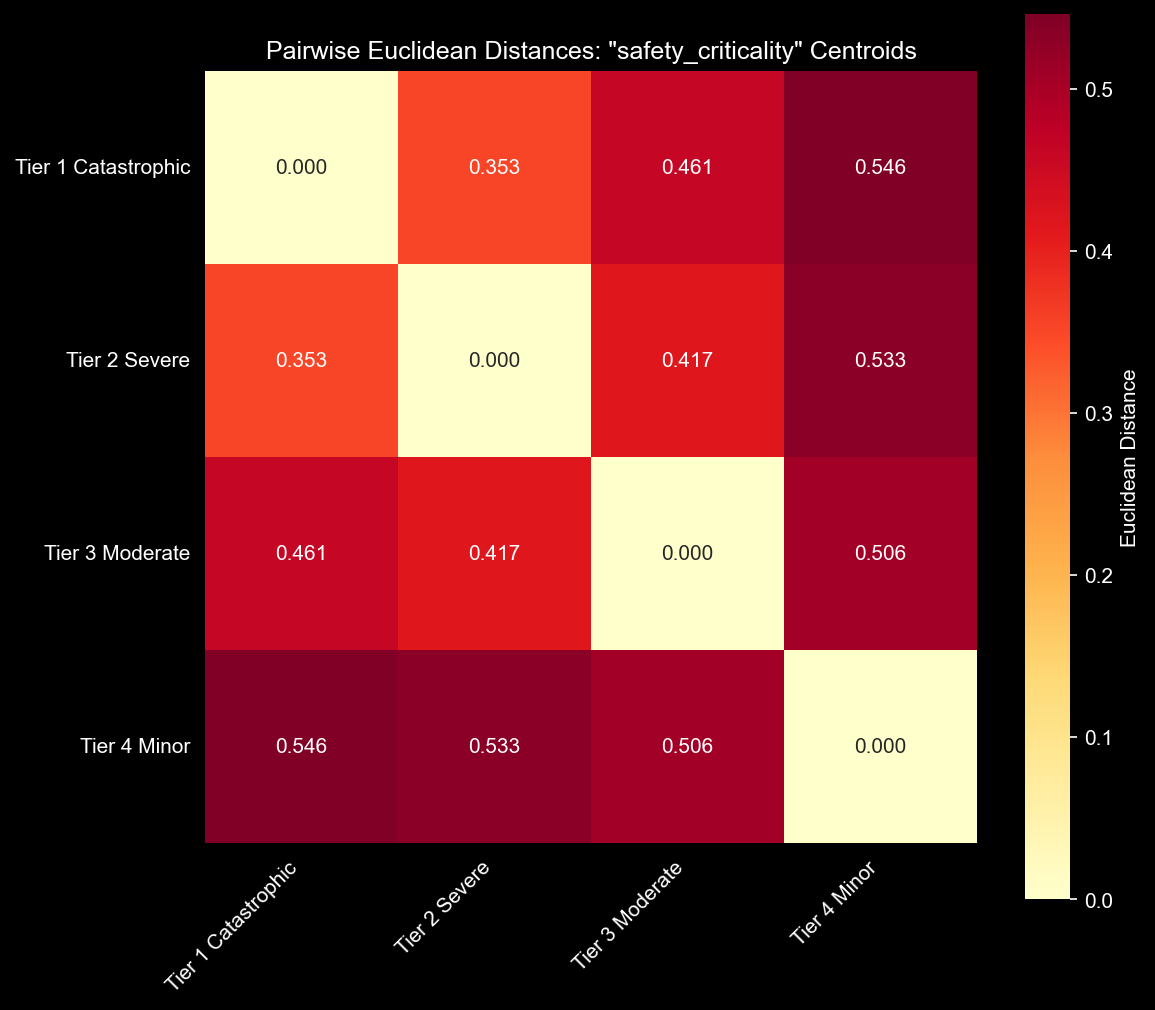

In [15]:
# Plot heatmap
fig, ax = plt.subplots(figsize=(8, 7))

sns.heatmap(sorted_dist_matrix,
            xticklabels=display_labels,
            yticklabels=display_labels,
            annot=True,
            fmt='.3f',
            cmap='YlOrRd',
            square=True,
            ax=ax,
            cbar_kws={'label': 'Euclidean Distance'})

ax.set_title('Pairwise Euclidean Distances: "safety_criticality" Centroids')
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
ax.set_yticklabels(ax.get_yticklabels(), rotation=0)
plt.tight_layout()

fig.savefig(FIGURE_DIR / '02_distance_safety.png', bbox_inches='tight')
plt.show()

## 5. Angular Separation Between Centroids

Compute and visualize the angular separation (in degrees) between centroids for selected keys.
Angular separation is computed from cosine similarity: theta = arccos(cosine_similarity).

In [16]:
def compute_angular_separation(centroids):
    """Compute pairwise angular separation in degrees between centroid vectors."""
    # Normalize centroids
    norms = np.linalg.norm(centroids, axis=1, keepdims=True)
    normalized = centroids / norms
    
    # Compute cosine similarity (dot product of normalized vectors)
    cos_sim = np.dot(normalized, normalized.T)
    
    # Clip to handle numerical errors
    cos_sim = np.clip(cos_sim, -1, 1)
    
    # Convert to angle in degrees
    angles_rad = np.arccos(cos_sim)
    angles_deg = np.degrees(angles_rad)
    
    return angles_deg

# Test with safety criticality
test_angles = compute_angular_separation(safety_centroids)
print(f'Angular separation matrix shape: {test_angles.shape}')
print(f'Angle range: [{test_angles.min():.2f}, {test_angles.max():.2f}] degrees')

Angular separation matrix shape: (4, 4)
Angle range: [0.00, 31.68] degrees


In [17]:
# Select keys for angular separation analysis
selected_keys = ['weather', 'road_type', 'safety_criticality', 'traffic_situation']

# Compute mean angular separation for each key
angular_stats = {}
for key in selected_keys:
    values, centroids = get_centroids_for_key(key)
    if len(values) > 1:
        angles = compute_angular_separation(centroids)
        # Get upper triangle (excluding diagonal)
        upper_tri = angles[np.triu_indices_from(angles, k=1)]
        angular_stats[key] = {
            'mean': np.mean(upper_tri),
            'std': np.std(upper_tri),
            'min': np.min(upper_tri),
            'max': np.max(upper_tri),
            'n_values': len(values)
        }

for key, stats in angular_stats.items():
    print(f'{key}: mean={stats["mean"]:.2f} +/- {stats["std"]:.2f} deg (range: {stats["min"]:.2f}-{stats["max"]:.2f})')

weather: mean=31.36 +/- 3.58 deg (range: 26.73-36.71)
road_type: mean=37.29 +/- 3.13 deg (range: 32.57-44.19)
safety_criticality: mean=27.16 +/- 3.99 deg (range: 20.31-31.68)
traffic_situation: mean=34.93 +/- 3.25 deg (range: 31.11-39.37)


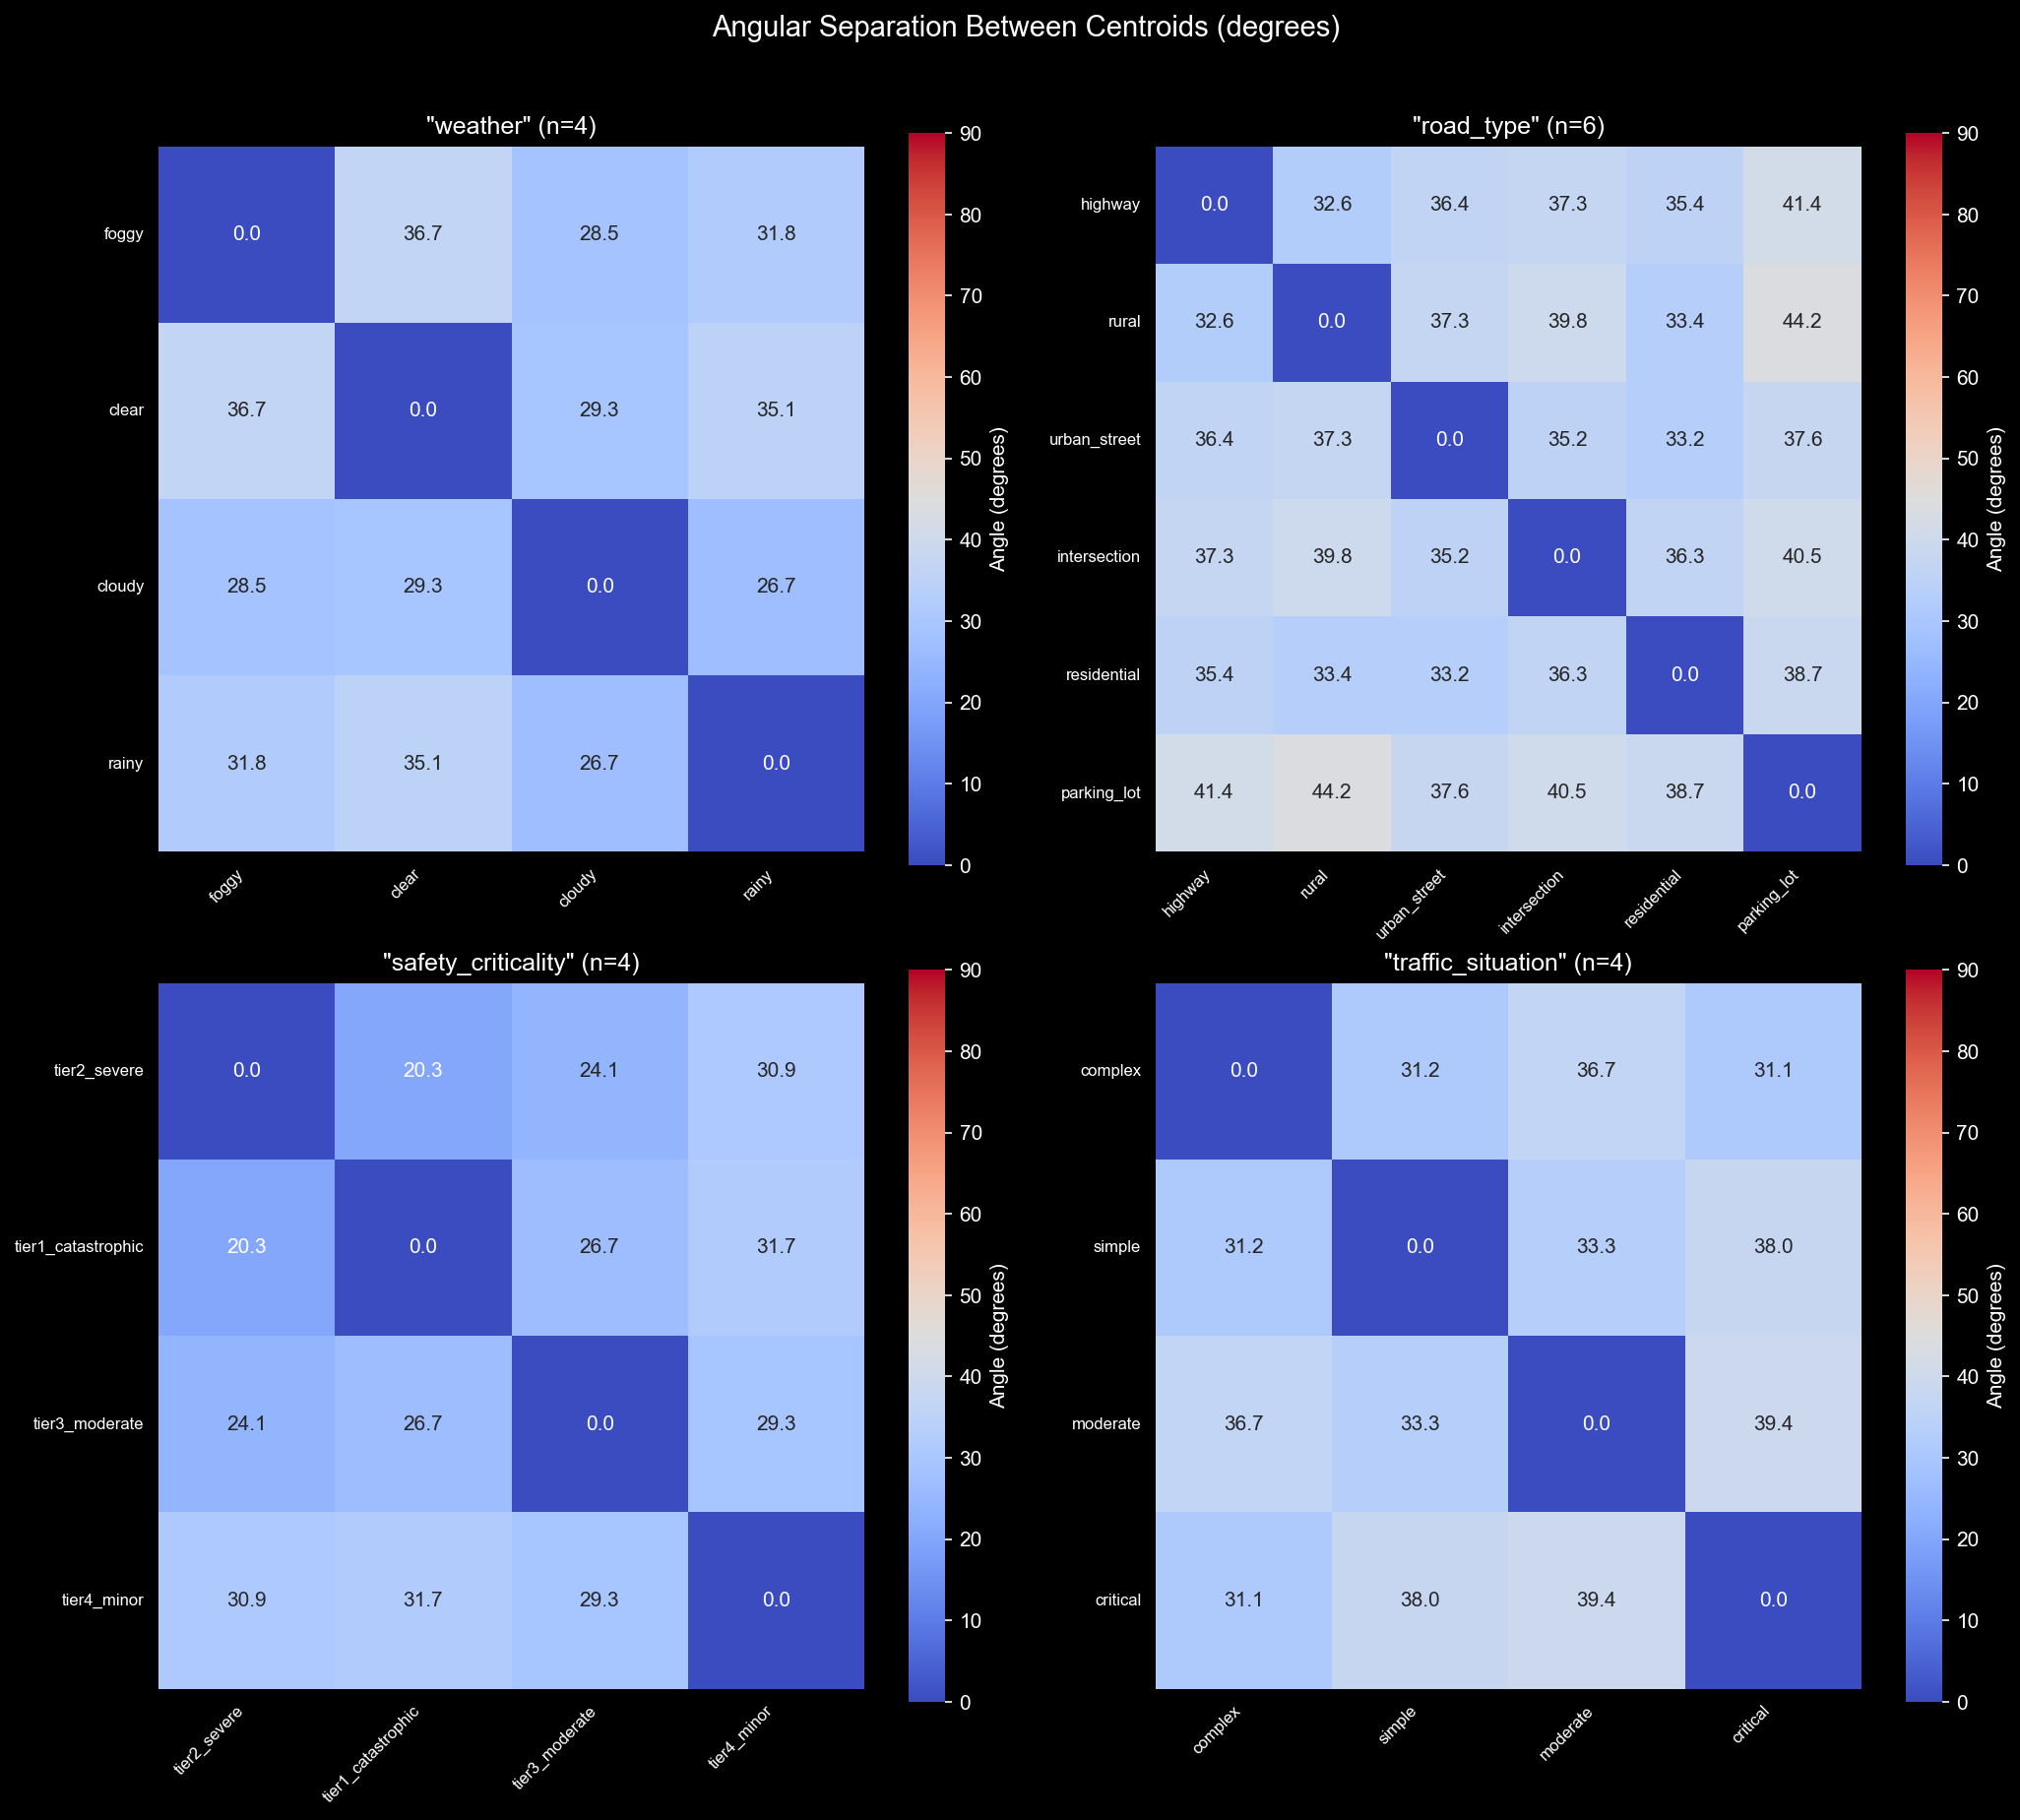

In [18]:
# Create visualization
fig, axes = plt.subplots(2, 2, figsize=(14, 12))
axes = axes.flatten()

for idx, key in enumerate(selected_keys):
    values, centroids = get_centroids_for_key(key)
    angles = compute_angular_separation(centroids)
    
    ax = axes[idx]
    
    # Plot heatmap
    im = sns.heatmap(angles,
                     xticklabels=values,
                     yticklabels=values,
                     annot=True,
                     fmt='.1f',
                     cmap='coolwarm',
                     center=45,
                     vmin=0, vmax=90,
                     square=True,
                     ax=ax,
                     cbar_kws={'label': 'Angle (degrees)'})
    
    ax.set_title(f'"{key}" (n={len(values)})')
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right', fontsize=8)
    ax.set_yticklabels(ax.get_yticklabels(), rotation=0, fontsize=8)

fig.suptitle('Angular Separation Between Centroids (degrees)', fontsize=14, y=1.02)
plt.tight_layout()

fig.savefig(FIGURE_DIR / '02_angular_separation.png', bbox_inches='tight')
plt.show()

## Summary

The centroid visualizations reveal:

1. **Centroid Counts**: Keys vary significantly in granularity, from binary (cyclists_present) to multi-valued (vehicle_count_by_type: 20 values)

2. **Road Type PCA**: The 6 road types show spatial separation in embedding space, with semantically similar types clustering together

3. **Weather PCA**: The 4 weather conditions are well-separated, indicating distinct semantic representations

4. **Safety Distance Matrix**: Reveals the embedding distance structure between criticality tiers

5. **Angular Separation**: Shows how semantically distinct different values are within each key (larger angles = more distinct)

In [19]:
# List generated figures
print('Generated figures:')
for f in sorted(FIGURE_DIR.glob('02_*.png')):
    print(f'  {f.name}')

Generated figures:
  02_angular_separation.png
  02_centroid_counts.png
  02_centroids_3d_road_type.png
  02_centroids_3d_weather.png
  02_centroids_road_type.png
  02_centroids_weather.png
  02_distance_safety.png


## 6. 3D PCA of Centroids

3D visualizations provide additional perspective on how centroids distribute in embedding space.

In [20]:
from mpl_toolkits.mplot3d import Axes3D

# 3D PCA for road_type centroids
pca_road_3d = PCA(n_components=3, random_state=42)
road_coords_3d = pca_road_3d.fit_transform(road_centroids)

print(f'Road type 3D PCA explained variance: {pca_road_3d.explained_variance_ratio_}')
print(f'Total explained (3 components): {sum(pca_road_3d.explained_variance_ratio_):.2%}')

Road type 3D PCA explained variance: [0.3030776  0.21871539 0.1847797 ]
Total explained (3 components): 70.66%


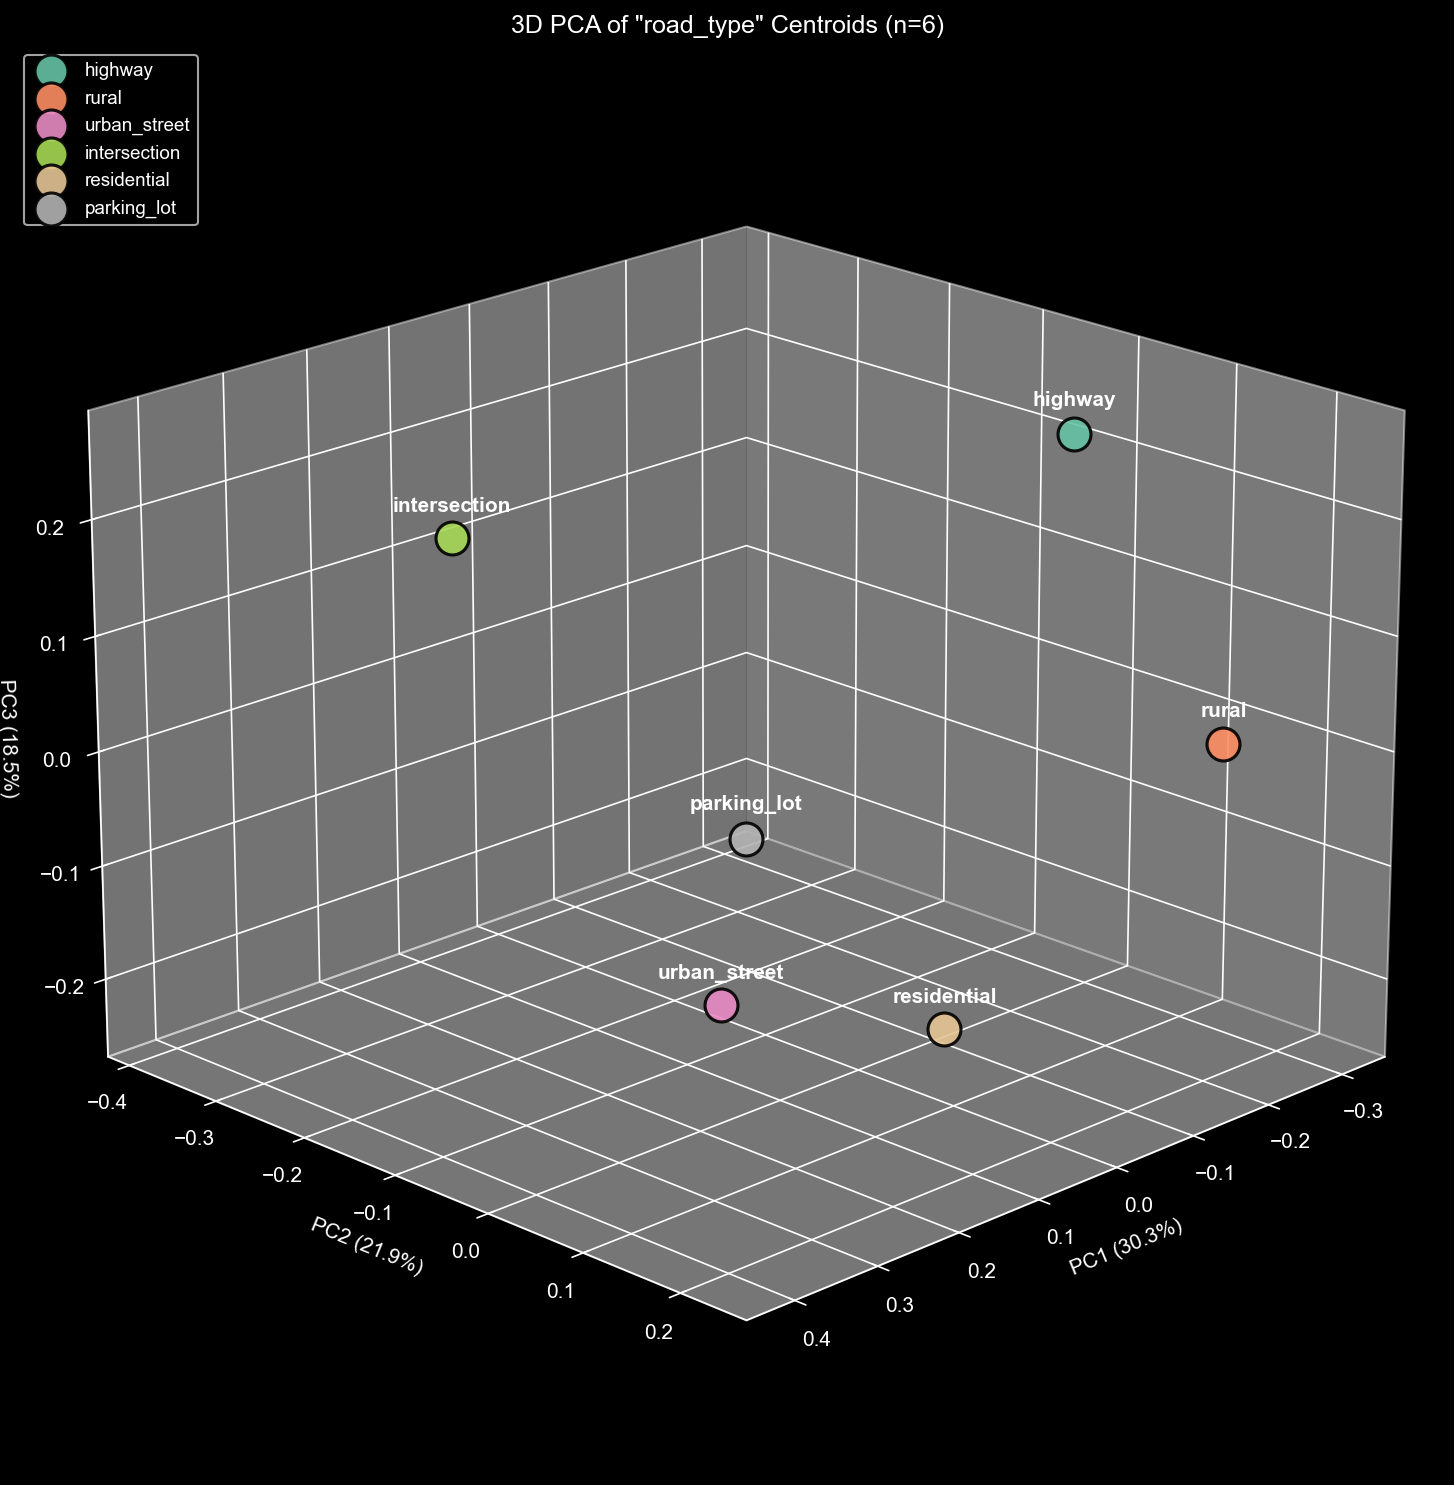

Saved: 02_centroids_3d_road_type.png


In [21]:
# 3D PCA plot for road_type centroids with labels
fig = plt.figure(figsize=(12, 10))
ax = fig.add_subplot(111, projection='3d')

colors = plt.cm.Set2(np.linspace(0, 1, len(road_values)))

for i, (val, coord) in enumerate(zip(road_values, road_coords_3d)):
    ax.scatter(coord[0], coord[1], coord[2], c=[colors[i]], s=250, alpha=0.9, 
               edgecolors='black', linewidth=1.5, label=val)
    ax.text(coord[0], coord[1], coord[2] + 0.02, val, fontsize=10, fontweight='bold',
            ha='center', va='bottom')

ax.set_xlabel(f'PC1 ({pca_road_3d.explained_variance_ratio_[0]:.1%})')
ax.set_ylabel(f'PC2 ({pca_road_3d.explained_variance_ratio_[1]:.1%})')
ax.set_zlabel(f'PC3 ({pca_road_3d.explained_variance_ratio_[2]:.1%})')
ax.set_title('3D PCA of "road_type" Centroids (n=6)')
ax.legend(loc='upper left', fontsize=9)

# Set viewing angle
ax.view_init(elev=20, azim=45)

plt.tight_layout()
fig.savefig(FIGURE_DIR / '02_centroids_3d_road_type.png', bbox_inches='tight')
plt.show()

print(f'Saved: 02_centroids_3d_road_type.png')

In [22]:
# 3D PCA for weather centroids
pca_weather_3d = PCA(n_components=3, random_state=42)
weather_coords_3d = pca_weather_3d.fit_transform(weather_centroids)

print(f'Weather 3D PCA explained variance: {pca_weather_3d.explained_variance_ratio_}')
print(f'Total explained (3 components): {sum(pca_weather_3d.explained_variance_ratio_):.2%}')

Weather 3D PCA explained variance: [0.46228712 0.33688942 0.20082346]
Total explained (3 components): 100.00%


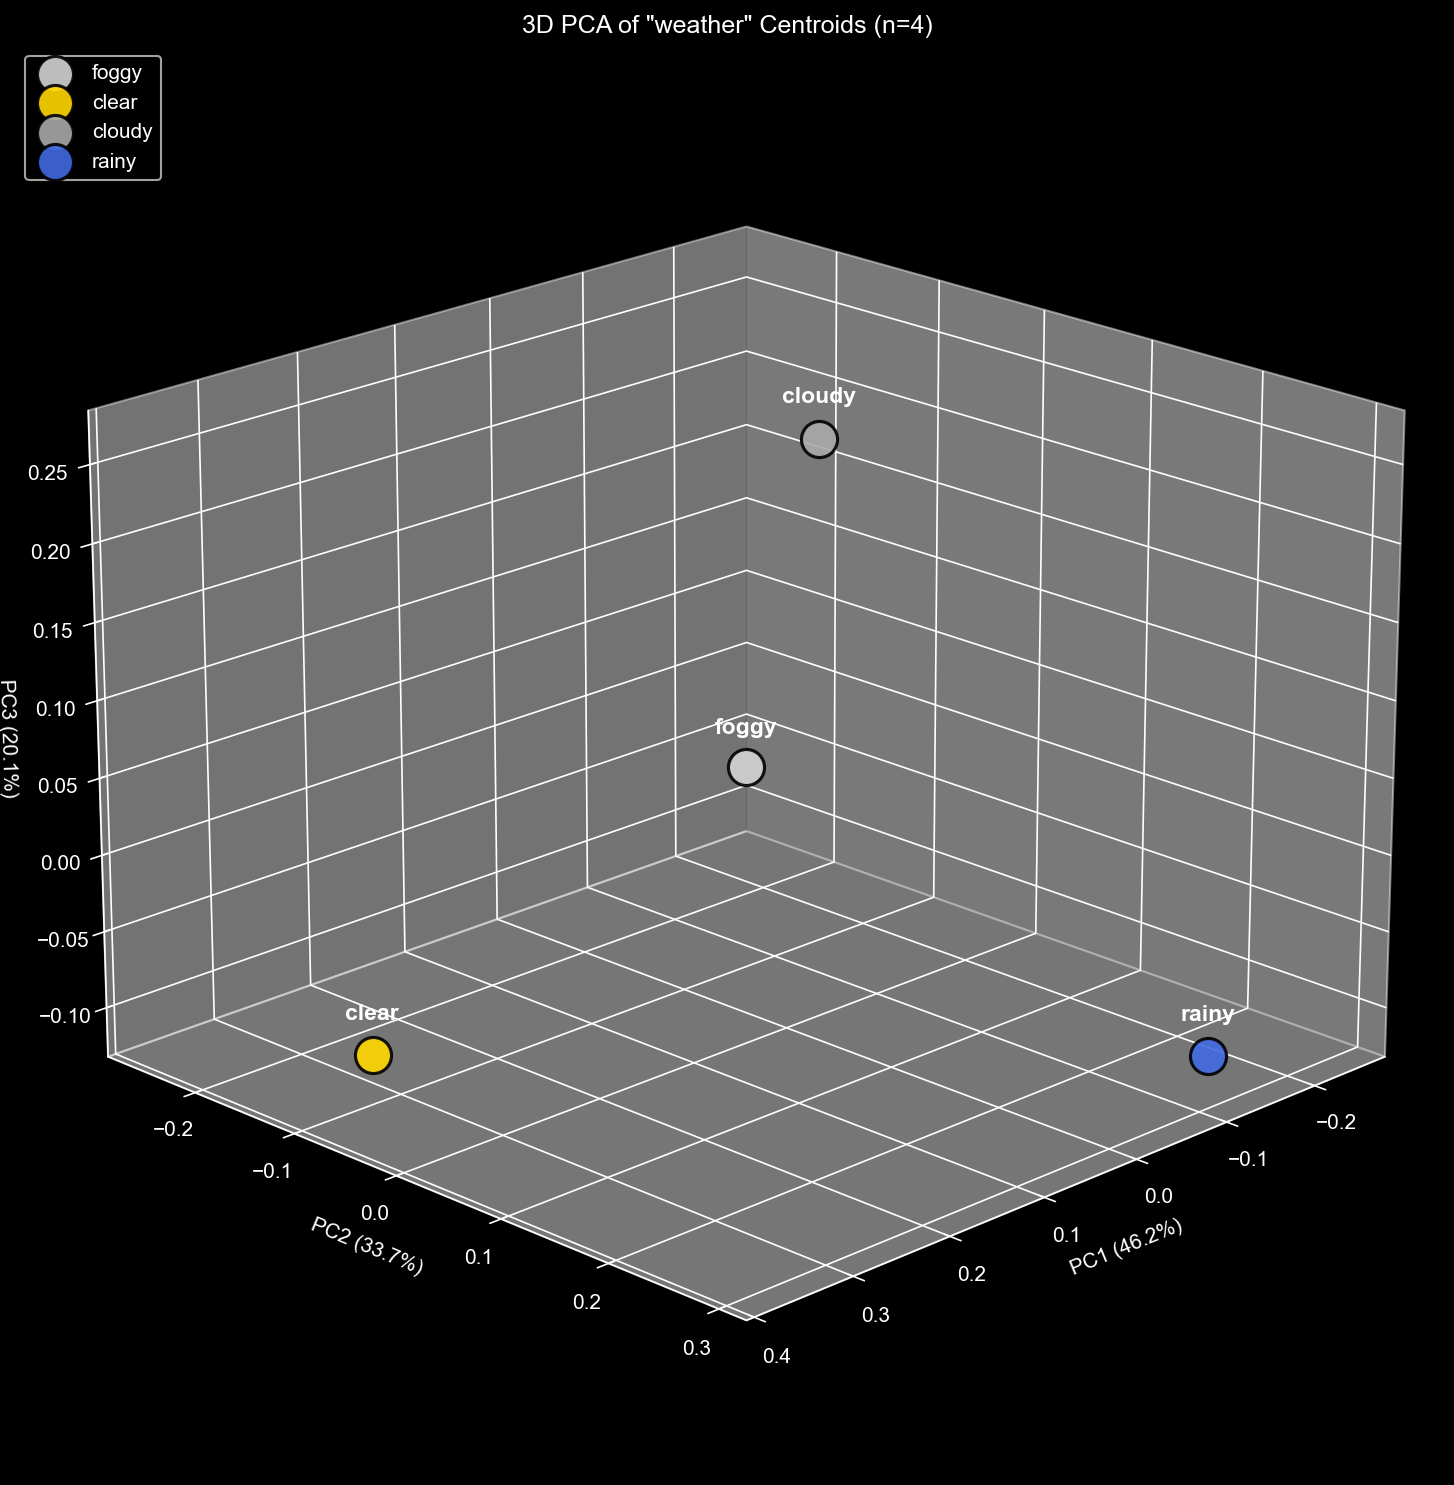

Saved: 02_centroids_3d_weather.png


In [23]:
# 3D PCA plot for weather centroids with labels
fig = plt.figure(figsize=(12, 10))
ax = fig.add_subplot(111, projection='3d')

# Use weather-appropriate colors
weather_colors = {
    'clear': '#FFD700',    # Gold/sunny
    'cloudy': '#A9A9A9',   # Gray
    'rainy': '#4169E1',    # Royal blue
    'foggy': '#D3D3D3'     # Light gray
}

for val, coord in zip(weather_values, weather_coords_3d):
    color = weather_colors.get(val, '#888888')
    ax.scatter(coord[0], coord[1], coord[2], c=color, s=300, alpha=0.9, 
               edgecolors='black', linewidth=1.5, label=val)
    ax.text(coord[0], coord[1], coord[2] + 0.02, val, fontsize=11, fontweight='bold',
            ha='center', va='bottom')

ax.set_xlabel(f'PC1 ({pca_weather_3d.explained_variance_ratio_[0]:.1%})')
ax.set_ylabel(f'PC2 ({pca_weather_3d.explained_variance_ratio_[1]:.1%})')
ax.set_zlabel(f'PC3 ({pca_weather_3d.explained_variance_ratio_[2]:.1%})')
ax.set_title('3D PCA of "weather" Centroids (n=4)')
ax.legend(loc='upper left', fontsize=10)

# Set viewing angle
ax.view_init(elev=20, azim=45)

plt.tight_layout()
fig.savefig(FIGURE_DIR / '02_centroids_3d_weather.png', bbox_inches='tight')
plt.show()

print(f'Saved: 02_centroids_3d_weather.png')